In [33]:
# tools

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [35]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=700)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [36]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example,"

In [37]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki,description="Query wikipedia")
print(wiki.name)

wikipedia


In [38]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [39]:
# Tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [ ]:
tavily.invoke("Tell me about ISRO 101st mission")

In [42]:
# combine all these tools in the list
tools = [arxiv,wiki,tavily]

In [43]:
# initialize the LLM mode

from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-8b-instant")

In [44]:
llm.invoke("Tell me about AI QA Engineering")

AIMessage(content='AI QA Engineering, also known as Artificial Intelligence Quality Assurance Engineering, is a subfield of software engineering that focuses on using artificial intelligence (AI) and machine learning (ML) technologies to improve the quality and efficiency of software testing and quality assurance (QA) processes.\n\n**Key Responsibilities:**\n\nAI QA Engineers are responsible for designing, implementing, and maintaining AI-powered testing solutions that can automatically identify bugs, defects, and issues in software applications. Their key responsibilities include:\n\n1. **Testing Automation**: Developing and maintaining automated testing frameworks, scripts, and tools to reduce manual testing efforts.\n2. **AI-Driven Testing**: Designing and implementing AI-powered testing solutions that can identify bugs, defects, and issues in software applications.\n3. **Predictive Maintenance**: Using AI and ML algorithms to predict potential issues and defects in software applica

In [45]:
llm_with_tools = llm.bind_tools(tools=tools)

In [46]:
llm_with_tools.invoke("What is the latest news about S-550")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e3ah', 'function': {'arguments': '{"query": "S-550 latest news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 394, 'total_tokens': 416, 'completion_time': 0.029333333, 'prompt_time': 0.01662519, 'queue_time': 0.048234059999999995, 'total_time': 0.045958523}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--aff134dd-d78e-4691-a6f2-993093eab928-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'S-550 latest news'}, 'id': 'call_e3ah', 'type': 'tool_call'}], usage_metadata={'input_tokens': 394, 'output_tokens': 22, 'total_tokens': 416})

In [47]:
# workflow

# state schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage # human message or AI message
from typing import Annotated # labelling
from langgraph.graph.message import add_messages # reducers in langgraph

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [48]:
# entire chatbot with langgraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [ ]:
# node definition

def llm_calling_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# build graph
builder = StateGraph(State)
builder.add_node("llm_calling_tool",llm_calling_tool)
builder.add_node("tools", ToolNode(tools))

# edges
builder.add_edge(START,"llm_calling_tool")
builder.add_conditional_edges(
    "llm_calling_tool",
    tools_condition
)
builder.add_edge("tools",END)

graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
messages = graph.invoke({"messages":"1706.03762"})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_4nvk)
 Call ID: call_4nvk
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, based
solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models

In [55]:
messages = graph.invoke({"messages":"What do you know about Attention is all you need"})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What do you know about Attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_ebjw)
 Call ID: call_ebjw
  Args:
    query: Attention is all you need
  wikipedia (call_2xvn)
 Call ID: call_2xvn
  Args:
    query: Attention is all you need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the pe

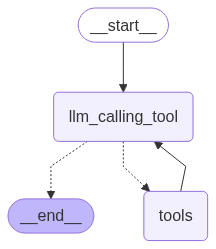

In [57]:
# node definition

def llm_calling_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# build graph
builder = StateGraph(State)
builder.add_node("llm_calling_tool",llm_calling_tool)
builder.add_node("tools", ToolNode(tools))

# edges
builder.add_edge(START,"llm_calling_tool")
builder.add_conditional_edges(
    "llm_calling_tool",
    tools_condition
)
builder.add_edge("tools","llm_calling_tool")

graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
messages = graph.invoke({"messages":"What do you know about Attention is all you need"})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What do you know about Attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_y61f)
 Call ID: call_y61f
  Args:
    query: Attention is all you need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We find that dropping dreeper attention layers only margina

In [59]:
messages = graph.invoke({"messages":"What is the current weather condition in Patna,India"})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the current weather condition in Patna,India
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ka1q)
 Call ID: call_ka1q
  Args:
    query: Patna India weather today
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weather in Patna, India", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Patna', 'region': 'Bihar', 'country': 'India', 'lat': 25.6, 'lon': 85.1167, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1747564364, 'localtime': '2025-05-18 16:02'}, 'current': {'last_updated_epoch': 1747564200, 'last_updated': '2025-05-18 16:00', 'temp_c': 33.1, 'temp_f': 91.6, 'is_day': 1, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/day/143.png', 'code': 1030}, 'wind_mph': 4.3, 'wind_kph': 6.8, 'wind_degr